In [1]:
import os
import sys
p = os.path.dirname(os.path.abspath('../algo-trading'))
sys.path.append(p)

os.chdir('../')
print(os.getcwd())

/Users/benjaminsmith/Developer/algo-trading


In [128]:
import pandas as pd
from pandas_datareader import data as web
import plotly.graph_objects as go
from common.database import QueryDatabase, GetTable

In [3]:
symbols = QueryDatabase("""SELECT distinct(symbol), count(*) FROM "finnhub_stock_candles_D" GROUP BY symbol;""")
len(symbols)

19974

In [129]:
SYM = 'PFE'
#res = QueryDatabase("""SELECT * FROM "finnhub_stock_candles_D" WHERE SYMBOL='{}' ORDER BY t""".format(SYM))
res = GetTable("finnhub_stock_candles_D", WHERE="SYMBOL='{}'".format(SYM))
res[0]

{'finnhub_stock_candles_D_index': 7599908,
 'created_at': datetime.datetime(2021, 12, 7, 0, 54, 20, 759106),
 'updated_at': datetime.datetime(2021, 12, 15, 18, 48, 53, 496353),
 'c': 36.3254,
 'h': 36.3823,
 'l': 36.1169,
 'o': 36.1169,
 's': 'ok',
 't': 1575849600,
 'v': 14971279,
 'symbol': 'PFE',
 'imbalance_tick': 0,
 'imbalance': 0.0,
 'imbalance_volume_weighted': 0.0,
 'RSI': None,
 'stoch_RSI': None}

In [133]:
# table = []
# for r in res:
#     entry = {}
#     for s, x in zip(['id','created_at','updated_at','c','h','l','o','s','t','v','symbol','imbalance_tick','imbalance','imbalance_volume'], r):
#         entry[s] = x
#     table.append(entry)
    
df = pd.DataFrame(res)
df['ts'] = pd.to_datetime(df['t'], unit='s')
df.index = df['ts']
df.sort_index(inplace=True)
df.head()

finnhub_stock_candles_D_index                 created_at  \
ts                                                                     
2019-12-09                        7599908 2021-12-07 00:54:20.759106   
2019-12-10                        7599909 2021-12-07 00:54:20.759106   
2019-12-11                        7599910 2021-12-07 00:54:20.759106   
2019-12-12                        7599911 2021-12-07 00:54:20.759106   
2019-12-13                        7599912 2021-12-07 00:54:20.759106   

                           updated_at        c        h        l        o   s  \
ts                                                                              
2019-12-09 2021-12-15 18:48:53.496353  36.3254  36.3823  36.1169  36.1169  ok   
2019-12-10 2021-12-15 18:48:53.496353  36.4771  36.5719  36.1974  36.2780  ok   
2019-12-11 2021-12-15 18:48:53.496353  36.2306  36.5624  36.2116  36.3728  ok   
2019-12-12 2021-12-15 18:48:53.496353  36.5339  36.6098  36.1832  36.1832  ok   
2019-12-13 2021-12-15 18:48:53.496353  36.3349  36.6667  36.0894  36.5150  ok   

                     t         v symbol  imbalance_tick  imbalance  \
ts                                                                   
2019-12-09  1575849600  14971279    PFE               0        0.0   
2019-12-10  1575936000  18189079    PFE               1        1.0   
2019-12-11  1576022400  14771736    PFE              -1        0.0   
2019-12-12  1576108800  12727846    PFE               1        1.0   
2019-12-13  1576195200  15824101    PFE              -1        0.0   

            imbalance_volume_weighted   RSI stoch_RSI         ts  
ts                                                                
2019-12-09                        0.0  None      None 2019-12-09  
2019-12-10                 18189079.0  None      None 2019-12-10  
2019-12-11                  3417343.0  None      None 2019-12-11  
2019-12-12                 16145189.0  None      None 2019-12-12  
2019-12-13                   321088.0  None      None 2019-12-13

In [134]:
trace1 = {
    'x': df.ts,
    'open': df.o,
    'close': df.c,
    'high': df.h,
    'low': df.l,
    'type': 'candlestick',
    'name': df.symbol.iloc[0],
    'showlegend': True
}

data = [trace1]
# Config graph layout
layout = go.Layout({
    'title': {
        'text': 'Price',
        'font': {
            'size': 15
        }
    }
})

In [135]:
fig = go.Figure(data=data, layout=layout)
fig.write_html("Stock Prices.html")
fig.show()

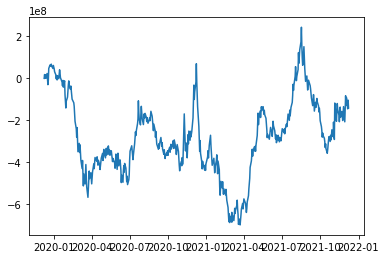

In [137]:
import matplotlib.pyplot as plt
plt.plot(df.imbalance_volume_weighted)

In [118]:
# RSI
# average % change up / |average % change down|
df['diff'] = (df['c'].diff().fillna(0) / df['c'])

In [119]:
df['avg_gain'] = df[df['diff']>0]['diff'].rolling(14).mean()
df['avg_gain'] = df['avg_gain'].interpolate()

In [120]:
df['avg_loss'] = df[df['diff']<0]['diff'].rolling(14).mean()
df['avg_loss'] = df['avg_loss'].interpolate()

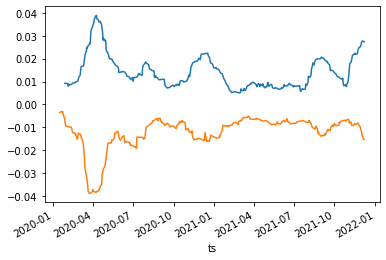

In [121]:
df['avg_gain'].plot()
df['avg_loss'].plot()
plt.show()

In [122]:
df['RSI'] = 1.0 - (1.0 / (1.0 + abs(df['avg_gain']/df['avg_loss']).fillna(0)))

In [123]:
# Stochastic RSI
x = df['RSI'].rolling(14)
df['stoch_RSI'] = (df['RSI'] - x.min()) / (x.max()-x.min())

In [124]:
plt.plot(df['RSI'])
plt.plot(df['stoch_RSI'])
plt.twinx()
plt.plot(df['imbalance_volume'], 'g')
plt.show()

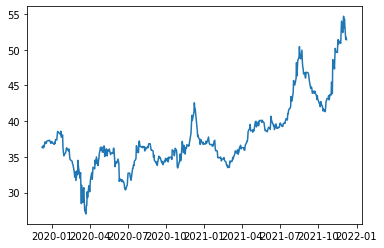

In [126]:
plt.plot(df.c)
plt.show()

In [4]:
# SCREENER!
#. want good volume, price in range < $500. Then look for volatility over a weekly range?
from datetime import datetime, timedelta
vol = QueryDatabase("""
SELECT distinct(symbol), avg(v) / 1000000.0, avg(o), count(*)
FROM "finnhub_stock_candles_D" 
WHERE t > {}
GROUP BY 1""".format((datetime.today() - timedelta(days=180)).timestamp() ))

In [5]:
table = []
for v in vol:
    table.append({'symbol': v[0], 'avg_vol_m': v[1], 'avg_open': v[2], 'avg_dollar_day': float(v[1])*v[2], 'samples': v[3]})
dfV = pd.DataFrame(table)
dfV.head()

symbol               avg_vol_m    avg_open  avg_dollar_day  samples
0      A      1.6023768560000000  156.948880      251.491253      125
1     AA      7.9838081200000000   43.364961      346.217526      125
2  AAALF  0.00076833333333333333   29.464667        0.022639        3
3   AABB     26.0793291280000000    0.136902        3.570312      125
4  AABVF  0.01307580808080808100    0.165560        0.002165       99

In [6]:
# Screen for: high avg volume, average open > $10, and traded for at least 120 days out of last 6 months
df2 = dfV.loc[(dfV['avg_vol_m'] > 10) & (dfV['avg_open'] > 10) & (dfV['samples'] > 120)]

In [7]:
for i,r in df2.iterrows():
    print(r)

symbol                            AAL
avg_vol_m         29.9510395760000000
avg_open                      20.7843
avg_dollar_day                622.511
samples                           125
Name: 18, dtype: object
symbol                           AAPL
avg_vol_m         77.4821891760000000
avg_open                      144.461
avg_dollar_day                11193.1
samples                           125
Name: 31, dtype: object
symbol                            AMC
avg_vol_m         99.8976532080000000
avg_open                       42.247
avg_dollar_day                4220.37
samples                           125
Name: 690, dtype: object
symbol                            AMD
avg_vol_m         55.6050995600000000
avg_open                       106.33
avg_dollar_day                5912.49
samples                           125
Name: 697, dtype: object
symbol                             BA
avg_vol_m         10.1553437280000000
avg_open                      226.229
avg_dollar_day              

In [8]:
len(df2)

22